# Multilayer perceptron

Pytorch framework documentation [here](https://pytorch.org/)

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#import time
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
from torchsummary import summary

## Load data - [MNIST](http://yann.lecun.com/exdb/mnist/)

In [40]:
# Load MNIST data
train_data = pd.read_csv( "/content/sample_data/mnist_train_small.csv"  , header=None)
test_data = pd.read_csv( "/content/sample_data/mnist_test.csv"  , header=None)

X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

print (X.shape, y.shape, X_test.shape, y_test.shape)

(20000, 784) (20000,) (10000, 784) (10000,)


In [16]:
# create train / test splits
#X_train, X_test, y_train, y_test = _

# Reshape to bidimensional (image) size
#X_train, X_test = _ , _

#print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

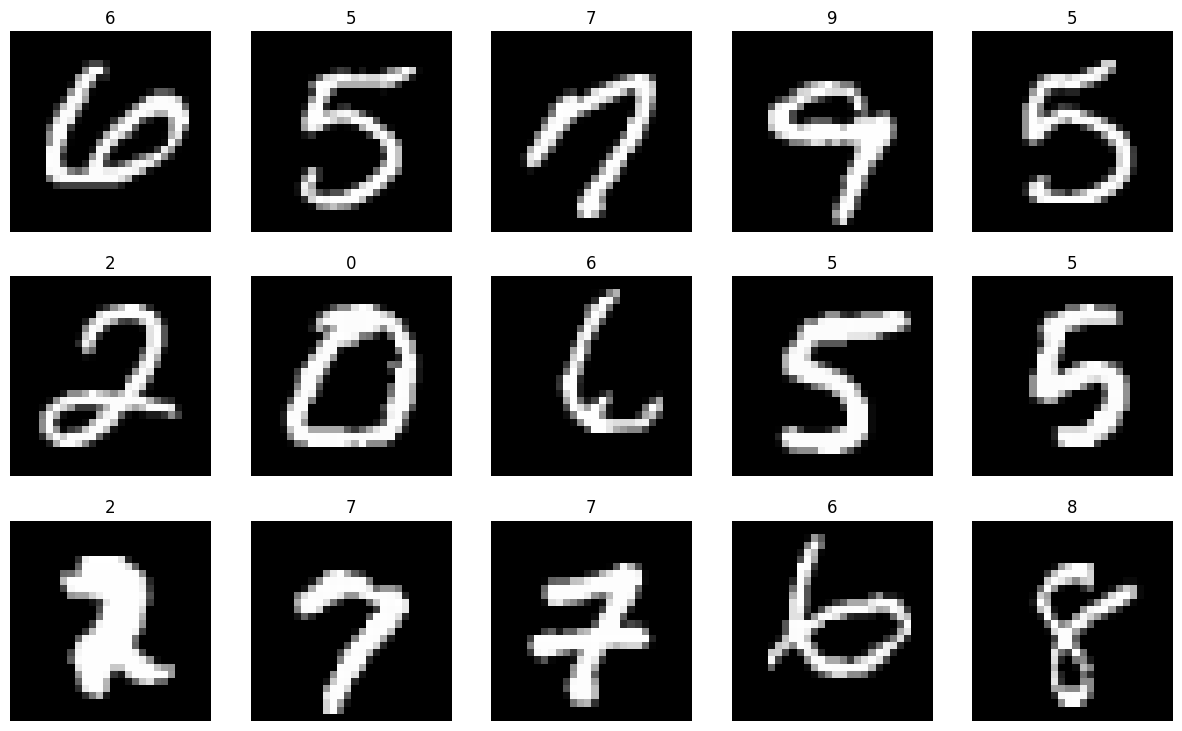

In [41]:
# Visualize grid of samples
grid_size = (3, 5)

_, axes = plt.subplots ( grid_size[0] , grid_size[1] , figsize=(grid_size[1]*3, grid_size[0]*3))
axes = axes.ravel()

for i, ax in enumerate(axes):
  ax.imshow( X_train[i].reshape([28, 28]), cmap='gray')
  ax.set_title(str(y_train[i]))
  ax.set_axis_off()


In [44]:
# Reshape the data - MLPs do not understand such '2D' stuff
# Reshape to 1D is similat to "flatten" an image

# Configuration options
feature_vector_length = 784
num_classes = 10

# Convert into 0 - 1 values
X_train = X_train / (X_train.max() - X_train.min())
X_test = X_test / (X_test.max() - X_test.min())

print (X_train.min(), X_train.max())
print (X_test.min(), X_test.max())

0.0 1.0
0.0 1.0


In [45]:
# Convert target classes to categorical ones - one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [48]:
print (X_train.shape, y_train.shape)

(20000, 784) (20000, 10)


## Create a graph model

In [51]:
model = torch.nn.Sequential(
  nn.Linear( feature_vector_length, 10 ), nn.ReLU(),
  nn.Linear( 10 , 10 ), nn.ReLU(),
  #nn.Linear( _ , _ ), nn.ReLU(),
  #nn.Linear( _ , _ ), nn.ReLU(),
  #nn.Linear( _ , _ ), nn.ReLU(),
  nn.Linear( 10 , num_classes ), nn.Softmax()
)

summary(model, input_size=(feature_vector_length,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              ReLU-4                   [-1, 10]               0
            Linear-5                   [-1, 10]             110
           Softmax-6                   [-1, 10]               0
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1845: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return inner()


## Define loss function and optimizer

In [ ]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = _ )

## Train model

In [ ]:
# Model params for training
epochs = 100
batch_size = 200 # We dont train the whole dataset at the time
losses = []

for _ : # Iterate over all the num of epochs
  #
  progress = _
  batch_losses = 0

  for _ : # Iterate over all batches of data
    #
    # First step, take the data from the dataset
    batch_X = _
    batch_y = _
    batch_X = torch.from_numpy(batch_X) # Convert to torch tensor to feed the graph
    batch_y = torch.from_numpy(batch_y) # Convert to torch tensor to feed the graph

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = _

    # Compute loss
    batch_loss = loss(predictions, batch_y)

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()

    ## Accumulate loss to compute mean over all batches
    batch_losses += batch_loss.item()

    # Compute time and show all progress
    elapsed_time = time.time() - start_time
    progress.set_description("[Epoch %d/%d] [Batch %d/%d] [Loss: %f] time: %3f" % (epoch, epochs,
                                                                          batch_i, len(X_train),
                                                                          batch_loss.item(),
                                                                          elapsed_time))

  # Save epoch loss
  losses.append(batch_losses/(len(X_train)/batch_size))




## Plot results

In [ ]:
# Plot progress (loss function)

## Compute metrics over ```X_test``` images

In [ ]:
progress = tqdm(range( _ , _ , _ ), ncols=100)
predictions = _

for _ : # Iterate over all batches of data
  #
  batch_X = _
  batch_y = _

  # Perform forward pass to compute predictions
  batch_predictions = _
  _  = _

y_test_ = np.argmax(y_test, axis=1)
acc = _
cm_ = _

# Compute confusion matrix and accuracy
_, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_, cmap="hot", annot=True, ax=ax)
print("acc: {0}".format(acc))